### !! note : bias and complex_additivefeature names are reserved, dont use.

In [2]:
#!pip uninstall -y interpret_lightgbm
!pip install git+https://github.com/m-elgebaly/interpret-lightgbm.git

  Cloning https://github.com/m-elgebaly/interpret-lightgbm.git to /tmp/pip-req-build-09fpz75q
  Running command git clone --filter=blob:none --quiet https://github.com/m-elgebaly/interpret-lightgbm.git /tmp/pip-req-build-09fpz75q
  Resolved https://github.com/m-elgebaly/interpret-lightgbm.git to commit 1e93e52e1f5eb7b6eb7d500cb93b38755bfea7ae
  Preparing metadata (setup.py) ... done
  Created wheel for interpret_lightgbm: filename=interpret_lightgbm-0.2.0-py3-none-any.whl size=20380 sha256=ca11657cf591d0965cefe5e1e1d1256f9b78724d6dcf2a06709e82d956a7ff5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-w66xtb1d/wheels/5f/71/fc/6040bf6f0afc574938acc20d16a667fe68d72abe1f8ea5c46a
Successfully built interpret_lightgbm
  Attempting uninstall: interpret_lightgbm
    Found existing installation: interpret_lightgbm 0.1.0
    Uninstalling interpret_lightgbm-0.1.0:
      Successfully uninstalled interpret_lightgbm-0.1.0


In [1]:
import interpret_lightgbm as ilb
ilb.__version__

'0.2.0'

In [2]:
import interpret_lightgbm as ilgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,f1_score
import lightgbm as lgb

In [3]:
from sklearn.datasets import fetch_california_housing
# 1. Load dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [4]:
num_rows = len(X)
random_uniform_values = np.random.rand(num_rows)

# Step 3: Add the new column to the DataFrame
X['random_uniform'] = random_uniform_values
# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lgbm = lgb.LGBMRegressor(n_estimators = 500, verbose=-1)
lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)

# 7. Evaluate all models
def evaluate(model_name, y_true, y_pred):
    print(f"{model_name} | f1: {mean_squared_error(y_true, y_pred)} | R2: {r2_score(y_true, y_pred):.4f}")


evaluate("LightGBM", y_test, y_pred_lgb)

LightGBM | f1: 0.19670846422506003 | R2: 0.8499


# Train data on Progressive LGBM

In [5]:


# 2. Define the parameters for the progressive training
# Base parameters applied to all models
base_params = {
    'n_estimators': 100,
    'learning_rate': 1,
    'num_leaves': 31,
    'seed': 42,
}

# Parameters specific to each depth. Here, we can override or add parameters.
# For example, we increase `n_estimators` as the model gets deeper.

depth_params = {
    1: {"n_estimators": 200, "learning_rate": 1, "min_child_samples": 10},
    2: {"n_estimators": 80, "learning_rate": 1},
    3: {"n_estimators": 30, "learning_rate": 1},#, "reg_alpha": 0.1}
    15: {"n_estimators": 300, "learning_rate": 0.1}#, "reg_alpha": 0.1}
}
# 3. Instantiate and fit the model
# We pass the evaluation metric we care about (optional, defaults to MSE for regression)
progressive_reg = ilgb.ProgressiveLGBMRegressor(
    base_params=base_params,
    depth_params=depth_params,
    eval_metric=mean_squared_error,
    verbose=True
)

# Fit the model using the train/test sets
progressive_reg.fit(X_train, y_train, X_test=X_test, y_test=y_test)

# 4. Access the stored attributes after fitting
print("\n--- Accessing Results ---")
print(f"Final Test Score (MSE): {progressive_reg.final_score_:.4f}")

# The models_ attribute is a dictionary where keys are the depths
print(f"Models were trained for depths: {list(progressive_reg.models_.keys())}")

# The contributions_ attribute contains SHAP values for each model at each depth
# Let's inspect the shape for the model with max_depth=4
final_depth = max(depth_params.keys())
print(f"Shape of contributions for depth {final_depth} model: {progressive_reg.contributions_[final_depth].shape}")
print("(Shape corresponds to: n_samples, n_features + 1 for bias)")


# 5. Make predictions on new data using the final fitted model
new_data = X_test.head(5)
predictions = progressive_reg.predict(new_data)
print("\n--- Making Predictions ---")
print("Predictions on 5 new samples:\n", predictions)

Running in Train-Test Split mode...
Depth   | Train MSE            | Eval MSE             | Train R2             | Eval R2             
------------------------------------------------------------------------------------------------------------------------
1       | 0.3088               | 0.3336               | 0.7690               | 0.7454              
2       | 0.2174               | 0.2474               | 0.8374               | 0.8112              
3       | 0.1897               | 0.2413               | 0.8581               | 0.8159              
15      | 0.0906               | 0.2171               | 0.9322               | 0.8343              

===== Train-Test Split Summary =====
Final Test Score (mean_squared_error): 0.2171

--- Accessing Results ---
Final Test Score (MSE): 0.2171
Models were trained for depths: [0, 1, 2, 3, 15]
Shape of contributions for depth 15 model: (4128, 10)
(Shape corresponds to: n_samples, n_features + 1 for bias)

--- Making Predictions ---
Predictions

# Plot contribution per feature

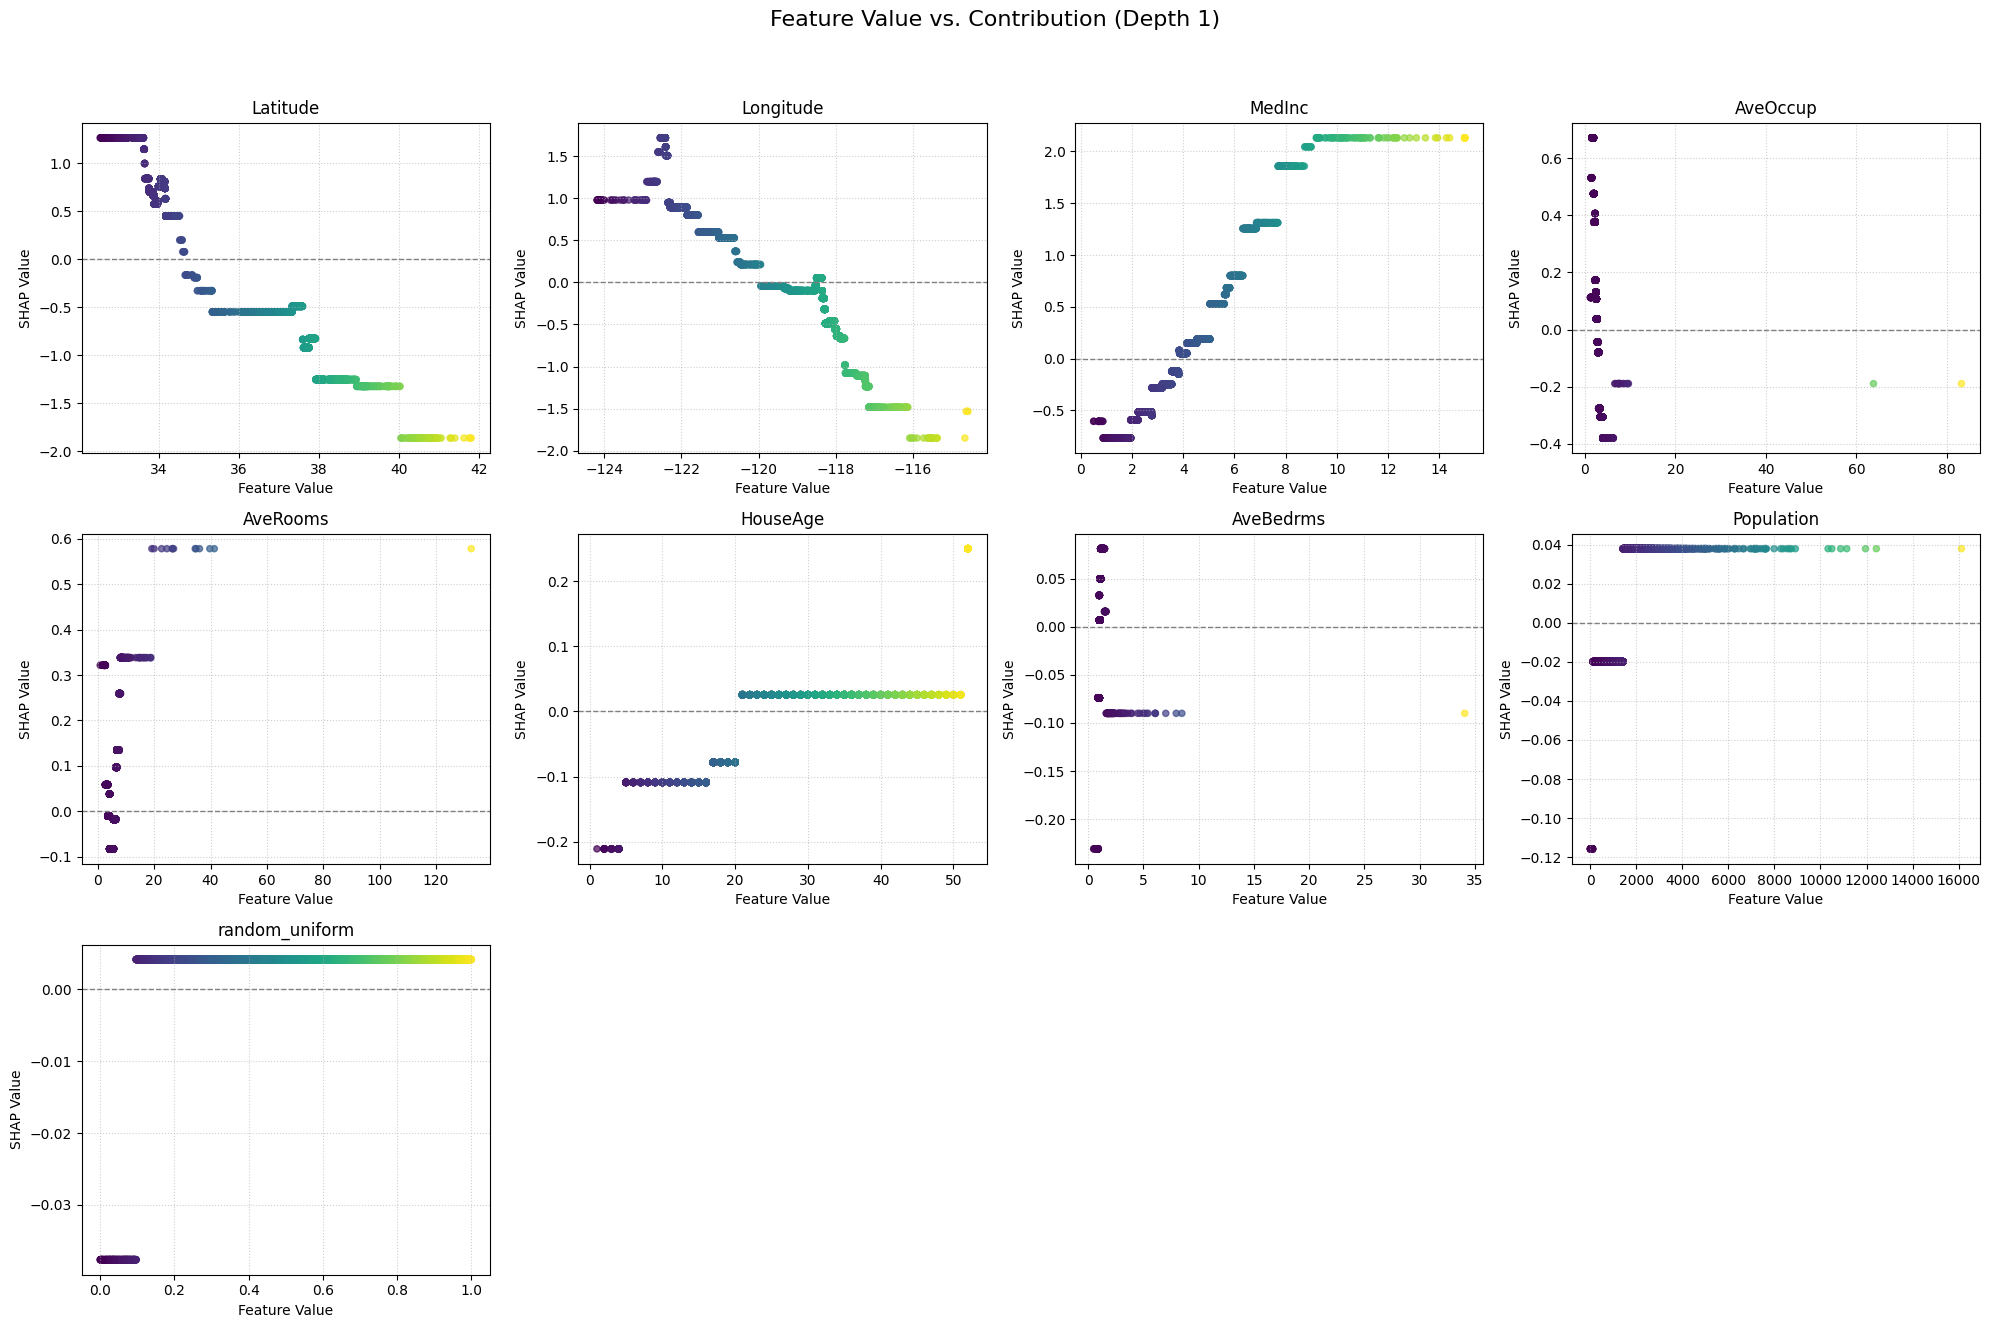

In [6]:
progressive_reg.plot_contributions(
    X_eval=X_test,
    depth=1,
    plot_type='scatter',
    #max_display=10  # Kwarg passed to the plotting function
)

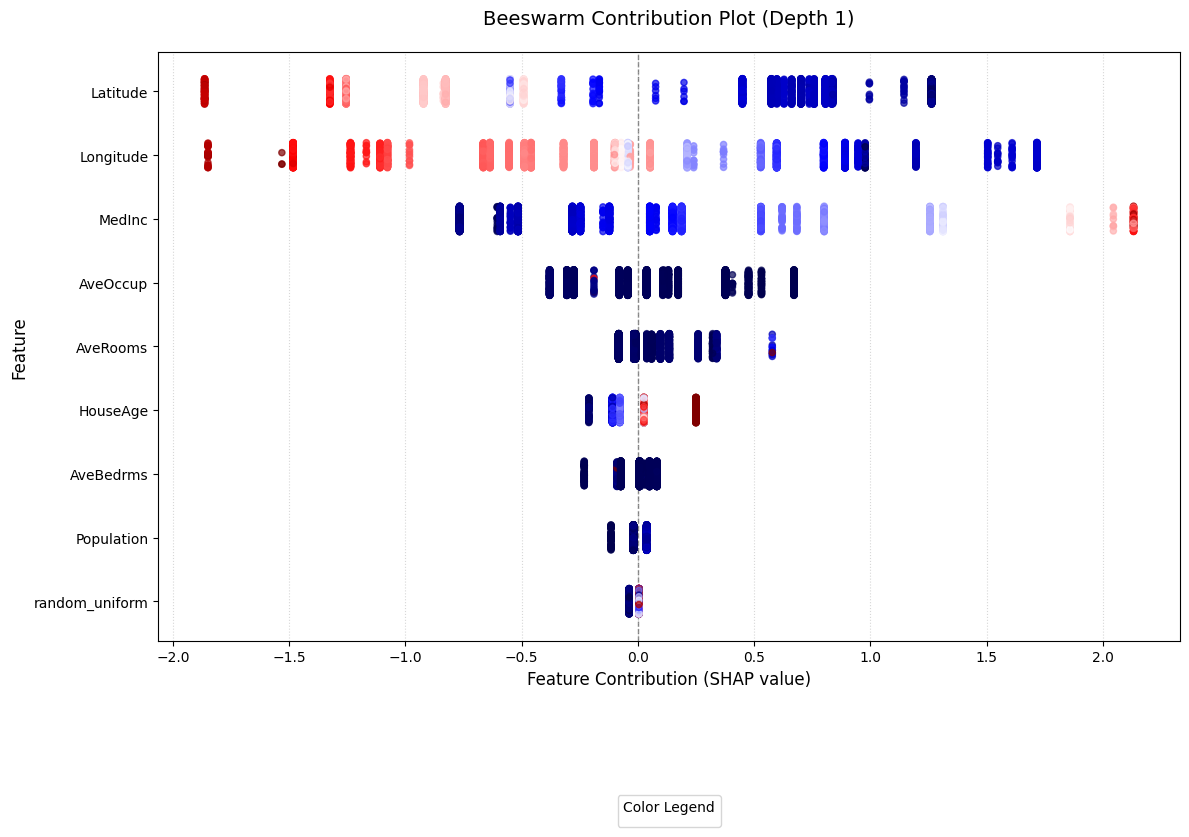

In [11]:
progressive_reg.plot_contributions(
    X_eval=X_test,
    depth=1,
    plot_type='beeswarm',
    #max_display=10  # Kwarg passed to the plotting function
)

# Find Contribution per feature upto max interactions specified

In [7]:
_, contrib_df, preds = progressive_reg.get_feature_contributions(
    X_eval=X_test.head(200),
    depth=3,
    raw=False)

Calculating Contributions:   0%|          | 0/200 [00:00<?, ?it/s]

# Filter low contributions, normalize and add complex additive feature (high complexity residual prediction added to simple models)

In [8]:
#works
filtered_contrib_df, report = progressive_reg.proccess_contribution_complex(
    contribution_df=contrib_df,
    y_test=y_test[:200],
    simple_model_depth=3,
    #complex_model_depth=progressive_reg.models_[15],
    X_test=X_test.head(200),
    #metric_fn=r2_score,
    min_abs_sum=0,
    reduction_ratio = 0.75)

filtered_contrib_df


Analyzing delta: Simple Model (depth=3) vs. Complex Model (depth=15)
{'columns_removed': 0, 'columns_added': 1, 'metric_value': 0.19595685111607317, 'complex_additive_mean_rank': 16, 'complex_additive_25th_rank': 8, 'complex_additive_75th_rank': 20, 'top_10_features':               Feature  MeanAbsContribution  MeanRank
0                bias             2.071947     1.020
1            Latitude             0.824263     2.560
2           Longitude             0.694743     3.895
3              MedInc             0.514027     4.065
4            AveOccup             0.206679     7.885
5  Latitude&Longitude             0.148207    10.475
6     AveOccup&MedInc             0.089655    11.390
7   AveOccup&HouseAge             0.080594    13.425
8            AveRooms             0.080389    14.045
9    complex_additive             0.069891    15.670}


,bias,MedInc,AveOccup,HouseAge,Latitude,Longitude,AveRooms,AveBedrms,Population,random_uniform,...,AveRooms&Latitude&MedInc,AveBedrms&Latitude&Longitude,AveOccup&Latitude&MedInc,AveRooms&Longitude&random_uniform,AveBedrms&AveOccup&random_uniform,AveOccup&AveRooms&Latitude,AveBedrms&AveRooms&random_uniform,AveOccup&random_uniform,Latitude&MedInc&Population,complex_additive
0,2.071947,-0.767432,-0.305279,0.025486,-0.550042,-0.211779,0.038219,0.006987,-0.019912,0.002592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033055
1,2.071947,-0.515949,0.037958,0.025486,-0.329433,-0.156808,-0.082525,0.081281,0.037914,0.002592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020566
2,2.071947,-0.248112,0.215476,0.249632,-0.827260,1.704443,-0.010389,0.081281,-0.019912,0.002592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282524
3,2.071947,0.683568,-0.305279,-0.078197,0.449325,-0.211779,-0.017590,0.006987,0.037914,0.002592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014513
4,2.071947,-0.123319,0.131307,0.025486,-0.550042,0.877944,-0.082525,0.006987,-0.019912,0.002592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.071947,-0.282320,-0.079349,0.025486,-0.550042,-0.186129,-0.017590,-0.073860,-0.019912,0.002592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087838
196,2.071947,0.050596,-0.305279,0.025486,0.449325,-0.211779,-0.017590,0.006987,0.037914,-0.045827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006431
197,2.071947,-0.282320,-0.379124,0.025486,0.837938,-1.457028,-0.082525,-0.073860,-0.019912,0.002592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060328
198,2.071947,2.131845,0.037958,0.025486,0.806772,-0.042844,0.338167,0.006987,0.037914,0.002592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.151552


# Visualize contributions per selected sample

In [9]:
# For SHAP force plot
ilgb.interpret_prediction(contributions_df = filtered_contrib_df,
                   instance_index = 3,
                   X_test = X_test,y_test =  y_test,
                   mode="forceplot",
                   threshold_abs=0.05)

Actual Value: 2.186


In [10]:
# For dataframe contribution visual
_ = ilgb.interpret_prediction(filtered_contrib_df, 3, X_test, y_test, mode="dataframe", threshold_abs=0.05)


Prediction analysis for instance: 3


,Feature Value,Contribution
Component,,
Baseline (Dataset Mean),,2.0719
MedInc,5.74,0.6836
Latitude,34.28,0.4493
AveOccup,3.44,-0.3053
Longitude,-118.72,-0.2118
AveRooms&Latitude,N/A,-0.1569
AveOccup&HouseAge,N/A,0.1287
AveOccup&MedInc,N/A,-0.1277
HouseAge,17.00,-0.0782
